# Biological Data group project

The following bash script downloads most of the required databases and installs locally some efficient implementations of algorithms as BLAST, PSI-BLAST, HMMER and TM-Align. The outputs of the executions we made are stored in the `../results/` directory, thus can be accessed without installing all this software.

In [ ]:
!bash setup.sh

The next cell installs all the libraries used in our notebook.

In [ ]:
!pip install -r ../requirements.txt

In [1]:
import pandas as pd

This is our assigned input for the project.

In [2]:
group = 13
assignment = pd.read_csv("../data/inputs.csv", index_col='Group')
assignment.loc[group]

UniProt                                                       P07237
Organism                                        Homo sapiens (Human)
Pfam ID                                                      PF00085
Pfam name                                         Thioredoxin domain
Domain position                                               26-131
Domain sequence    VLVLRKSNFAEALAAHKYLLVEFYAPWCGHCKALAPEYAKAAGKLK...
Name: 13, dtype: object

We encode a `.fasta` file for our input sequence for convenience.

In [ ]:
with open("../data/sequence.fasta", "w") as f:
    header = '>' + '|'.join(assignment.loc[group, :"Domain position"]) + '\n'
    f.write(header)
    f.write(assignment.loc[group, 'Domain sequence'])

# 1 Building the models

In [ ]:
import requests
import json

## 1.1 Define the groud truth
As a ground truth we retrieve the proteins belonging to the PFAM of our assignment sequence. We can do this using the InterPro API. The output of the HTTP request is a `.json` file. We prune the unnecessary information (everything but accession, start, end and length of the domain sequence) and we dump it to another `.json` to be reimported later.

In [ ]:
db_url = "https://www.ebi.ac.uk/interpro/api/protein/reviewed/"
query = "entry/pfam/PF00085/"
url = db_url + query
domain_proteins = {}

In [ ]:
while url != None:
    response = requests.get(url).json()
    total_entries = response['count']

    for result in response['results']:
        accession = result['metadata']['accession']
        length = result['metadata']['length']

        for entry_protein_location in result['entries'][0]['entry_protein_locations']:
            value = {
                "start": entry_protein_location['fragments'][0]['start'],
                "end": entry_protein_location['fragments'][0]['end'],
                "length": length
            }
            domain_proteins.setdefault(accession, []).append(value)

    url = response['next']

In [ ]:
with open('../results/groud_truth.json', 'w') as f:
    json.dump(domain_proteins, f)

## 1.2 BLAST search
To preliminary find some similar sequences we performed a BLAST search against SwissProt. Making some considerations regarding the oncoming MSA, we set up an $E$-value threshold of $10^{-20}$ to limit the hits to the most significant ones.

In [ ]:
%%bash
rm ../results/blast.out
../binx/ncbi-blast-2.11.0+/bin/blastp \
    -query ../data/sequence.fasta \
    -db ../data/db/uniprot_sprot.fasta \
    -outfmt "6 sseqid sseq" \
    -evalue 1e-20 \
    > ../results/blast.out

Here's a preview of the BLAST output:

In [ ]:
%%bash

head -n 10 "../results/blast.out"
echo "..." && echo "Total hits:"
cat "../results/blast.out" | wc -l

sp|P07237|PDIA1_HUMAN	VLVLRKSNFAEALAAHKYLLVEFYAPWCGHCKALAPEYAKAAGKLKAEGSEIRLAKVDATEESDLAQQYGVRGYPTIKFFRNGDTASPKEYTAGREADDIVNWLKK
sp|Q5R5B6|PDIA1_PONAB	VLVLRKSNFAEALAAHKYLLVEFYAPWCGHCKALAPEYAKAAGKLKAEGSEIRLAKVDATEESDLAQQYGVRGYPTIKFFRNGDTASPKEYTAGREADDIVNWLKK
sp|Q2HWU2|PDIA1_MACFU	VLVLRKSNFAEALAAHKYLLVEFYAPWCGHCKALAPEYAKAAGKLKAEGSEIRLAKVDATEESDLAQQYGVRGYPTIKFFRNGDTASPKEYTAGREADDIVNWLKK
sp|P04785|PDIA1_RAT	VLVLKKSNFAEALAAHNYLLVEFYAPWCGHCKALAPEYAKAAAKLKAEGSEIRLAKVDATEESDLAQQYGVRGYPTIKFFKNGDTASPKEYTAGREADDIVNWLKK
sp|P09103|PDIA1_MOUSE	VLVLKKSNFEEALAAHKYLLVEFYAPWCGHCKALAPEYAKAAAKLKAEGSEIRLAKVDATEESDLAQQYGVRGYPTIKFFKNGDTASPKEYTAGREADDIVNWLKK
sp|Q8R4U2|PDIA1_CRIGR	VLVLKKSNFAEALAAHNYLLVEFYAPWCGHCKALAPEYAKAAAKLKAEGSEIRLAKVDATEESDLAQQYGVRGYPTIKFFKNGDTASPKEYTAGREADDIVNWLKK
sp|P05307|PDIA1_BOVIN	VLVLHKGNFDEALAAHKYLLVEFYAPWCGHCKALAPEYAKAAGKLKAEGSEIRLAKVDATEESDLAQQYGVRGYPTIKFFKNGDTASPKEYTAGREADDIVNWLKK
sp|P21195|PDIA1_RABIT	VLVLKSSNFAEELAAHKHLLVEFYAPWCGHCKALAPEYAKAAGKLKAEGSDIRLAKVDATEESDLAQQYGVRGYPTI

This output file can be easily converted to FASTA format. In order to avoid quirks with T-Coffee we considered only unique sequences.

In [ ]:
visited = set()

with open("../results/blast.out") as src:
    with open("../data/blast.fasta", "w") as out:
        for line in src:
            header, sequence = line.split("\t")
            if sequence not in visited:
                out.write(">" + header + "\n" + sequence.replace("-", ""))
                visited.add(sequence)

print(f"{len(visited)} unique sequences written to FASTA file.")

65 unique sequences written to FASTA file.


## 1.3 T-Coffee MSA


The following is a Python wrapper to query the online EBI T-Coffee service via HTTP request. The output of the execution can be found in `../results/tcoffee/msa/`.

In [ ]:
%%bash

python tcoffee.py \
    --email email@example.com \
    --stype protein \
    --sequence ../data/blast.fasta \
    --format fasta_aln \
    --outfile ../results/tcoffee/msa \
    > /dev/null

echo "Done."

Done.
JobId: tcoffee-R20210127-103053-0444-4148344-p1m


This is a preview of the FASTA output:

In [ ]:
!head ../results/tcoffee/msa.aln-fasta.fasta

>sp|A3KPF5|PDI15_ARATH
VLELNGDYTKRVI-DG---NEFVMVLGYAPWCARSAELMPRFAEAATALKEI---GSSVL
MAKIDGDR--Y--SKIASELEIKGFPTLLLFVNG----------TSLTYNGGSSAEDIVI
WVQK
>sp|D3Z6P0|PDIA2_MOUSE
ILVLNHRTLSLAL-QE---HSALMVEFYAPWCGHCKELAPEYSKAAALLAAE---SAVVT
LAKVDGPA--E--PELTKEFEVVGYPTLKFFQNGN-----R--TNPEEYAGPKTAEGIAE
WLRR
>sp|D4B2L8|PDI_ARTBC
VHALKTDTFKDFI-KE---HDLVLAEFYAPWCGHCKALAPEYEKAATELKS-----KNIQ


Finally, we used JalView to check the presence of noise, but we decided to consider the noise acceptable and to not remove information.

## 1.3 PSSM model & PSI-BLAST

This next call generates a PSSM model which is stored in the file `../models/out_model_pssm.pssm`. Additionally, it prints a preview of the latter.


In [ ]:
%%bash
../binx/ncbi-blast-2.11.0+/bin/psiblast \
    -in_msa ../data/msa-jalview.fasta \
    -db ../data/db/uniprot_sprot.fasta \
    -out_pssm ../models/out_model_pssm.pssm \
    > /dev/null

head -n 20 ../models/out_model_pssm.pssm

PssmWithParameters ::= {
  pssm {
    isProtein TRUE,
    numRows 28,
    numColumns 103,
    byRow FALSE,
    query seq {
      id {
        swissprot {
          name "PDI15_ARATH",
          accession "A3KPF5",
          release "reviewed"
        }
      },
      inst {
        repr raw,
        mol aa,
        length 103,
        seq-data iupacaa "VLELNGDYTKRVIDGNEFVMVLGYAPWCARSAELMPRFAEAATALKEIGSSV
LMAKIDGDRYSKIASELEIKGFPTLLLFVNGTSLTYNGGSSAEDIVIWVQK"


Using the above model, we can perform a PSI-BLAST search against SwissProt database.

In [ ]:
%%bash
rm ../results/psiblast.out
../binx/ncbi-blast-2.11.0+/bin/psiblast \
    -in_pssm ../models/out_model_pssm.pssm \
    -db ../data/db/uniprot_sprot.fasta \
    -outfmt 6 -num_iterations 4 -evalue 1e-5 \
    > ../results/psiblast.out

head -n 10 ../results/psiblast.out

A3KPF5	sp|Q17770|PDI2_CAEEL	43.689	103	58	0	1	103	25	127	1.18e-55	182
A3KPF5	sp|Q17770|PDI2_CAEEL	25.714	105	72	4	1	102	365	466	1.27e-34	126
A3KPF5	sp|P13667|PDIA4_HUMAN	28.431	102	73	0	2	103	180	281	5.10e-53	178
A3KPF5	sp|P13667|PDIA4_HUMAN	30.097	103	72	0	1	103	64	166	3.07e-47	162
A3KPF5	sp|P13667|PDIA4_HUMAN	22.222	108	78	4	1	103	527	633	4.13e-33	123
A3KPF5	sp|P38659|PDIA4_RAT	29.000	100	71	0	2	101	178	277	3.27e-52	175
A3KPF5	sp|P38659|PDIA4_RAT	29.126	103	73	0	1	103	62	164	3.17e-47	162
A3KPF5	sp|P38659|PDIA4_RAT	21.296	108	79	4	1	103	525	631	6.71e-32	120
A3KPF5	sp|P08003|PDIA4_MOUSE	29.412	102	72	0	2	103	173	274	3.28e-52	175
A3KPF5	sp|P08003|PDIA4_MOUSE	29.126	103	73	0	1	103	57	159	9.11e-47	161


## 1.4 HMM model & HMM search

Similarly, we created a HMM model and perform HMM search against SwissProt. Output previews are displayed in both cells.

In [ ]:
%%bash
../binx/hmmer-3.3.1/src/hmmbuild \
    ../models/out_model_hmm.hmm \
    ../data/msa-jalview.fasta
    
head -n 20 "../models/out_model_hmm.hmm"

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.1 (Jul 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/msa-jalview.fasta
# output HMM file:                  ../models/out_model_hmm.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     msa-jalview            115   124   105     1.22  0.590 

# CPU time: 0.10u 0.00s 00:00:00.10 Elapsed: 00:00:00.10
HMMER3/f [3.3.1 | Jul 2020]
NAME  msa-jalview
LENG  105
ALPH  amino
RF    no
MM    no
CONS  yes
CS    no
MAP   yes
DATE  Wed Jan 27 11:18:53 2021
NSEQ  115
EFFN  1.217804
CKSUM 3946512571
STATS LOCAL MSV       -9.4113  0.71639
STATS

In [ ]:
%%bash
../binx/hmmer-3.3.1/src/hmmsearch \
    --domtblout ../results/hmm.hmmer_domtblout \
    -E 1e-5 \
    ../models/out_model_hmm.hmm \
    ../data/db/uniprot_sprot.fasta \
    > /dev/null

head -n 10 ../results/hmm.hmmer_domtblout

#                                                                             --- full sequence --- -------------- this domain -------------   hmm coord   ali coord   env coord
# target name         accession   tlen query name           accession   qlen   E-value  score  bias   #  of  c-Evalue  i-Evalue  score  bias  from    to  from    to  from    to  acc description of target
# ------------------- ---------- ----- -------------------- ---------- ----- --------- ------ ----- --- --- --------- --------- ------ ----- ----- ----- ----- ----- ----- ----- ---- ---------------------
sp|P38659|PDIA4_RAT   -            643 msa-jalview          -            105  1.2e-113  377.4   0.4   1   3   3.5e-40   4.6e-37  131.3   0.1     1   103    62   162    62   164 0.97 Protein disulfide-isomerase A4 OS=Rattus norvegicus OX=10116 GN=Pdia4 PE=1 SV=2
sp|P38659|PDIA4_RAT   -            643 msa-jalview          -            105  1.2e-113  377.4   0.4   2   3   2.5e-42   3.2e-39  138.2   0.0     2   103 

## 1.5 Models evaluation

We evaluated our models with two distinct approaches:
* computing the confusion matrix on the matching/mismatching accession codes between the ground truth set and our hits;
* computing a confusion matrix for each matching accession code based on the matching/mismatching residues and then considering the average of these matrices.

To do so, we import some functions that, for brevity, we defined in separated `.py` files. In particular we need:
* a parsing function for each model to translate their output into a handy data structure;
* some convenience methods for computing accuracy, precision, sensitivity, specificity, F1-score and MCC.

In [ ]:
from parsers import parsePsiBlastOutput, parseHmmerOutput
from metrics import seq_metrics, pos_metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In order to compute metrics we need to find out the cardinality of the database we used for retrieving the ground truth set and to perform PSI-BLAST and HMMER searches. 

In [ ]:
response = r.get(db_url)
db_num = response.json()['count']

with open("../results/groud_truth.json", "r") as f:
    ground_truth = json.load(f)

In [ ]:
model_hits_pssm = parsePsiBlastOutput("../results/psiblast.out")

518 hits parsed


In [ ]:
model_hits_hmm = parseHmmerOutput("../results/hmm.hmmer_domtblout")

437 hits parsed


### Sequence metrics

In [ ]:
metrics_seq = pd.DataFrame(
    [
        seq_metrics(model_hits_pssm, ground_truth, db_num),
        seq_metrics(model_hits_hmm, ground_truth, db_num)
    ],
    index=["PSSM", "HMM"]
)
metrics_seq

,Accuracy,Precision,Sensitivity,Specificity,F1-score,MCC
PSSM,0.999853,0.876448,0.959831,0.999886,0.916246,0.917120
HMM,0.999837,0.935927,0.864693,0.999950,0.898901,0.899525


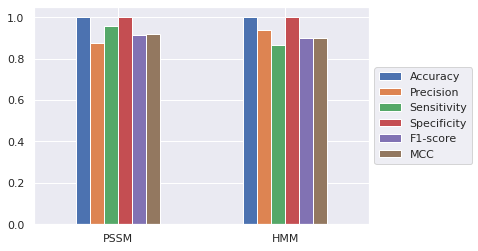

In [ ]:
ax = metrics_seq.plot(kind="bar")
_ = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)

plt.savefig("../plots/seq_metrics.pdf", bbox_inches='tight')

### Position metrics

In [ ]:
metrics_pos = pd.DataFrame(
    [
        pos_metrics(model_hits_pssm, ground_truth),
        pos_metrics(model_hits_hmm, ground_truth)
    ],
    index=["PSSM", "HMM"]
)
metrics_pos

,Accuracy,Precision,Sensitivity,Specificity,F1-score,MCC
PSSM,0.978998,0.957120,0.992406,0.969928,0.974444,0.957079
HMM,0.944079,0.914861,0.955859,0.935544,0.934911,0.886590


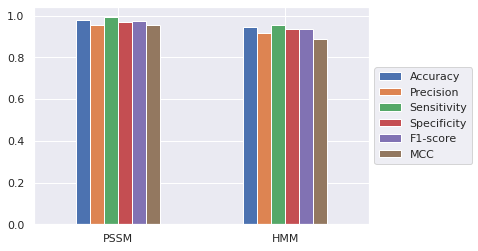

In [ ]:
ax = metrics_pos.plot(kind="bar")
_ = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)

plt.savefig("../plots/pos_metrics.pdf", bbox_inches='tight')

Accoring to metrics PSSM performs better. In the end, we can write the sequences accessions of both model on files.

In [ ]:
with open("../data/model_sequences.txt", "w") as f:
    f.write('\n'.join(list(model_hits_pssm.keys())))

# 2 Structural characterization

In [ ]:
import pandas as pd
import numpy as np
import requests
from Bio.PDB import PDBList
import os
import re

With the below cell, we retrieved the relation between accession codes and PDB ids. This table can be retrieved from [SIFTS](https://www.ebi.ac.uk/pdbe/docs/sifts/quick.html).

In [ ]:
%%bash

wget -P ../data/ ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/csv/uniprot_pdb.csv.gz
gunzip ../data/uniprot_pdb.csv.gz

--2021-01-28 09:19:06--  ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/csv/uniprot_pdb.csv.gz
           => ‘../data/uniprot_pdb.csv.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/msd/sifts/flatfiles/csv ... done.
==> SIZE uniprot_pdb.csv.gz ... 784347
==> PASV ... done.    ==> RETR uniprot_pdb.csv.gz ... done.
Length: 784347 (766K) (unauthoritative)

     0K .......... .......... .......... .......... ..........  6%  211K 3s
    50K .......... .......... .......... .......... .......... 13%  610K 2s
   100K .......... .......... .......... .......... .......... 19% 21.1M 1s
   150K .......... .......... .......... .......... .......... 26% 23.4M 1s
   200K .......... .......... .......... .......... .......... 32%  637K 1s
   250K .......... .......... ........

## 2.1 Retrieval of `family_structure`


After importing the `.csv` file, we filter with our model sequences and perform some data cleaning operations.

In [ ]:
pdb_dataset = pd.read_csv("../data/pdb_chain_uniprot.csv", skiprows=1, na_values = "None") 

with open("../data/model_sequences.txt", "r") as f:
    model_proteins = list(map(lambda x: x[:-1], f.readlines()))

# Filter PDB entries with our accession codes
pdb_dataset = pdb_dataset.loc[pdb_dataset["SP_PRIMARY"].isin(model_proteins)]

# Remove null values
pdb_dataset = pdb_dataset.dropna()

# Cast PDB_* to the correct numeric dtype
pdb_dataset = pdb_dataset.astype({"PDB_BEG": np.int64, "PDB_END": np.int64})

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Some protein sequences may cointain only partially certain domain sequences. In the following cells we compute the the coverage for each couple PDB-sequence and we put this quantity in a dataframe column. 

In [ ]:
def pdb_coverage(pdb_beg, pdb_end, sp_beg, sp_end):

    pdb = set(range(pdb_beg, pdb_end + 1))
    sp = set(range(sp_beg, sp_end + 1))

    return len(pdb.intersection(sp)) / len(pdb)

In [ ]:
for row in pdb_dataset.loc[:, "PDB_BEG": "SP_END"].itertuples():
    index, pdb_beg, pdb_end, sp_beg, sp_end = row
    pdb_dataset.loc[index, "COVERAGE"] = pdb_coverage(pdb_beg, pdb_end, sp_beg, sp_end)

Then, we filter entries with a 81% coverage threshold to keep only significant PDBs. This choice was made in order
to keep the number of retrieved PDBs under the limits of mTM-align online service.

In [ ]:
threshold = .81

family_structure = []
for sp in pdb_dataset.SP_PRIMARY.unique():
    idx = pdb_dataset.COVERAGE[pdb_dataset.SP_PRIMARY == sp].idxmax()
    if pdb_dataset.loc[idx, "COVERAGE"] > threshold:
        family_structure.append(pdb_dataset.loc[idx, "PDB"])

print(f"{len(family_structure)} PDB selected")

31 PDB selected


Finally, we can download a PDB file for each selected PDB.

In [ ]:
!rm -r ../data/structure/*

for pdb_id in family_structure:
    # Fetch a PDB file to the current dir
    pdbl = PDBList()
    pdbl.retrieve_pdb_file(pdb_id, pdir='../data/structure/', file_format='pdb')

## 2.2 Pairwise TM-Align

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

The folder created in the cell below will contain the output files of the pairwise structural alignments performed with TM-Align.

In [ ]:
%%bash

if [ -d ../data/structure/tmalign ]
    then rm -r ../data/structure/tmalign
fi
mkdir ../data/structure/tmalign

In the following block, we encode a bash command that executes TM-Align for each couple of PDBs. We considered only the strictly upper triangle for saving computational effort.

In [ ]:
for a, pdbA in enumerate(family_structure):
    for b, pdbB in enumerate(family_structure[a + 1:]):

        # Structure alignment with TM align
        statement =  "../binx/TMalign "
        statement += f"../data/structure/pdb{pdbA}.ent "
        statement += f"../data/structure/pdb{pdbB}.ent "
        statement += f"> ../data/structure/tmalign/{pdbA}_{pdbB}.out"

        os.system(statement)

Parsing the outputs, we can calculate RMSD and TM-score similarity matrices and display them with heatmaps.

In [ ]:
rmsd = np.zeros((len(family_structure), len(family_structure)))
tm_score = np.ones((len(family_structure), len(family_structure)))

for a, pdbA in enumerate(family_structure):
    for b, pdbB in enumerate(family_structure[a+1:]):
        b = b + a + 1 # This is a fix to make (a,b) run in the strictly upper triangle

        with open(f"../data/structure/tmalign/{pdbA}_{pdbB}.out", "r") as f:
            rmsd_line, score1, score2 = f.readlines()[16:19]
            score1 = score1.split(" ")
            score2 = score2.split(" ")

        equals = list(re.finditer("=", rmsd_line))
        commas = list(re.finditer(",", rmsd_line))

        rmsd[a, b] = float(rmsd_line[equals[1].span()[1] : commas[1].span()[0]])
        rmsd[b, a] = rmsd[a, b]
        tm_score[a, b] = float(score1[1])
        tm_score[b, a] = float(score2[1])

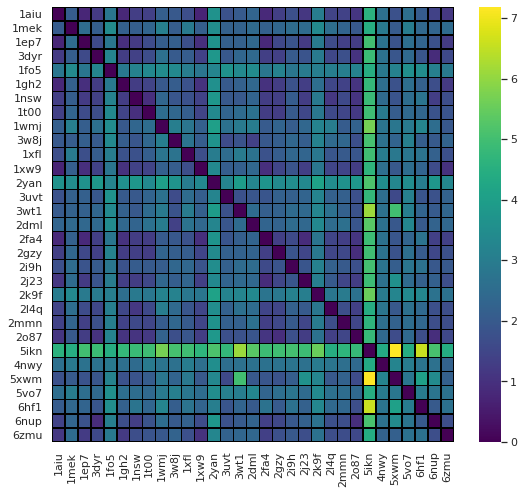

In [ ]:
fig = plt.figure(figsize=(9,8))
_ = sns.heatmap(rmsd, cmap='viridis', linewidths=.3, linecolor="black", xticklabels=family_structure, yticklabels=family_structure)

plt.savefig("../plots/rmsd.pdf", bbox_inches='tight')

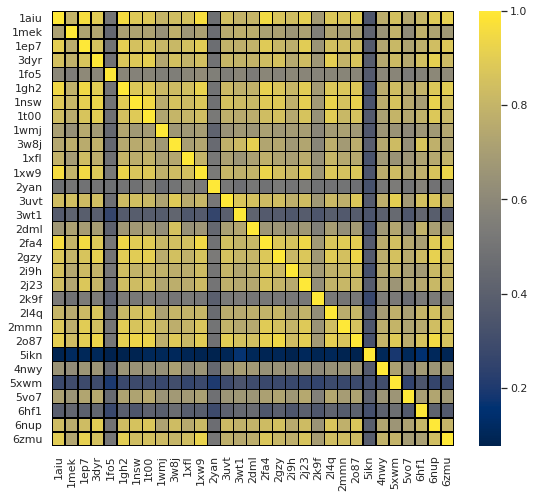

In [ ]:
fig = plt.figure(figsize=(9,8))
_ = sns.heatmap(tm_score, cmap='cividis', linewidths=.3, linecolor="black", xticklabels=family_structure, yticklabels=family_structure)

plt.savefig("../plots/tm_score.pdf", bbox_inches='tight')

## 2.3 Dendrograms and Outliers

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

We computed the outliers of the distribution of minimum RMSD per PDB against the others and removed them from `family_structure`, since they have a structure which is significantly different from the rest.

In [ ]:
min_rmsd = (rmsd + np.eye(rmsd.shape[0]) * rmsd.max()).min(axis=0)
q1, q3 = np.quantile(min_rmsd, [.25, .75])
f_1 = q1 - (q3 - q1) * 1.5
f_3 = q3 + (q3 - q1) * 1.5

outliers = np.argwhere((f_1 > min_rmsd) | (min_rmsd > f_3)).flatten()
print(f"There is/are {len(outliers)} outlier(s).")

There is/are 1 outlier(s).


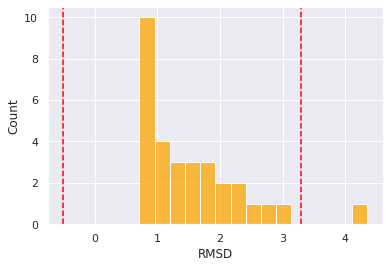

In [ ]:
sns.histplot(min_rmsd, color = 'orange', stat = 'count', bins = 15)
plt.axvline(f_1, ls = '--', c = 'red')
plt.axvline(f_3, ls = '--', c = 'red')
plt.xlabel("RMSD")

plt.savefig("../plots/rmsd_hist.pdf", bbox_inches = 'tight')

In order to feed correctly `scipy.cluster.hierarchy.linkage` we can use `scipy.spatial.distance.squareform` to transform the RMSD distance matrix into condensed form.

In [ ]:
condensed_rmsd = squareform(rmsd)

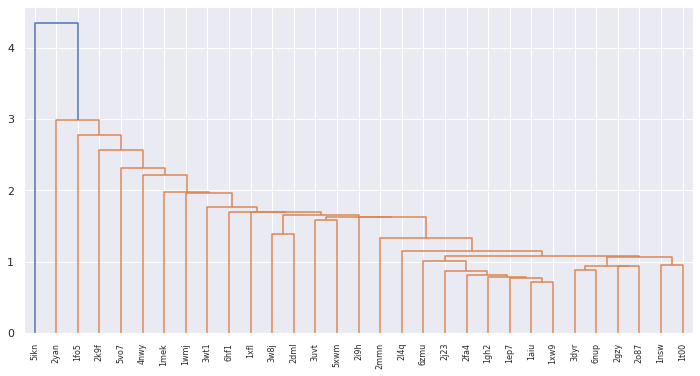

In [ ]:
labelList = [pdb.split('\n')[0] for pdb in family_structure]
fig = plt.figure(figsize = (12, 6))

dendrogram(linkage(condensed_rmsd, method = 'single'), leaf_rotation = 90, color_threshold=f_3, labels=family_structure)

plt.savefig("../plots/dendrogram.pdf", bbox_inches = 'tight')

We can now remove the spotted outliers:

In [ ]:
family_structure = [family_structure[i] for i in range(len(family_structure)) if i not in outliers]

## 2.4 Multiple Structural Alignment

A multiple structural alignment is computationally very expensive. However, the online mTM-Align service provided by [Yang-Lab](https://yanglab.nankai.edu.cn/mTM-align/) can't be accessed programmatically. Thus, to obtain a suitable input, we have to pack all our `.pdb` files in a compressed `.tar` archive.

In [ ]:
import tarfile

In [ ]:
with tarfile.open("../data/family_structure.tar", "w") as tar:
    for pdb in family_structure:
        PATH = f"../data/structure/pdb{pdb}.ent"
        tar.add(name = PATH, arcname = f"pdb{pdb}.ent")

In [ ]:
%%bash

if [ -e ../data/family_structure.tar.gz ]
    then rm ../data/family_structure.tar.gz
fi
gzip ../data/family_structure.tar

One can now use `family_structure.tar.gz` as input for the [mTM-align](https://yanglab.nankai.edu.cn/mTM-align/) online service. The results we got can be found in `../results/` folder. The output files are:
* `result.pdb`: the complete alignment, composed by all the structures with transformed coordinates;
* `cc.pdb`: the common core alignment, namely all the structures cut to the successfully aligned parts.

In case you can make use of a powerful hardware, the following cells can be used to run locally mTM-align. The first one writes a `.txt` file to be used as input, and it contains the filenames of the domains. The second one consists of bash commands to run mTM-align executable (after amking sure it can be executed), clean the unnecessary outputs and move the useful ones in the correct positions.

In [ ]:
with open("../data/family_structures.txt", "w") as f:
    for pdb in family_structure:
        f.write(f"../data/structure/pdb{pdb}.ent\n")

In [ ]:
%%bash

sudo chmod 777 ../binx/mTM-align
../binx/mTM-align \
    -i ../data/family_structures.txt

rm infile pairwise_TMscore.txt pairwise_rmsd.txt  result.fasta
mv -t ../results/ result.pdb cc.pdb

## 2.5 Distance matrices

In [ ]:
from Bio.PDB import PDBList, NeighborSearch
from Bio.PDB.PDBParser import PDBParser
from pdb_distance_matrix import get_distance_matrix

Now we can parse the PDB file containing the aligned structure.

In [ ]:
structure = PDBParser(QUIET=True).get_structure("common_core", "../results/cc.pdb")
chains = structure[0]

Notice that mTM-Align output handles our PDBs chains as chains of the same PDB. 

Now we can compute a distance matrix for each domain structure. Since we want to ignore the in-sequence closeness in favour of in-structure closeness, we set a threshold number of sequence positions. If two residuals sequence IDs distance is smaller of this threshold, then the distance between these residuals won't be computed.

In [ ]:
seq_sep = 12
distance_matrix = [get_distance_matrix(chain, seq_sep) for chain in chains]

The following plot is a heatmap representing each PDB distance matrix.
The grey areas are NaN values corresponding couples of residuals falling inside the sequence separation threshold.
The irregularity of their shape is due to the gaps between residues of the common core, introduced by mTM-align.

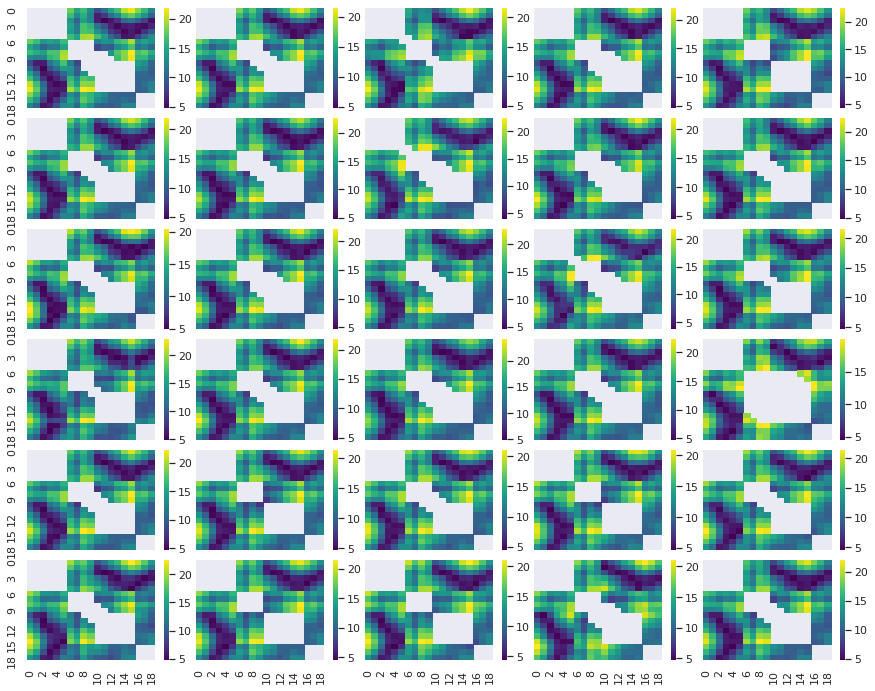

In [ ]:
ncols = 5
nrows = int(np.ceil(len(distance_matrix) / ncols))

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(3*ncols, 2*nrows))
plt.subplots_adjust(wspace=.05, hspace=.1)

for i, dm in enumerate(distance_matrix):
    sns.heatmap(distance_matrix[i], ax=ax[i//ncols, i%ncols], cmap='viridis')

plt.savefig("../plots/distance_matrices.pdf", bbox_inches='tight')

## 2.6 Contact maps

Using the distance matrices computed in the previous section, we can compute a contact map for each domain given a certain distance threshold (in 
Ångström).


In [ ]:
contact_thresh = 8
contact_map = [(mat < contact_thresh).astype(float) for mat in distance_matrix]

Then we can compute the average contact map to spot the most conserved positions.


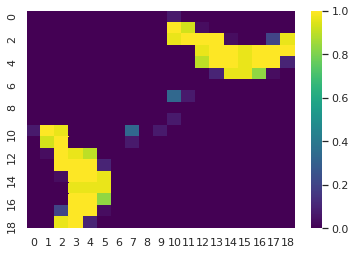

In [ ]:
avg_contact = np.mean(contact_map, axis=0)
_ = sns.heatmap(avg_contact, cmap='viridis')

plt.savefig("../plots/contact_map.pdf", bbox_inches='tight')

## 2.7 CATH superfamily

In [ ]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt

Once again, we can retrieve from [SIFTS](https://www.ebi.ac.uk/pdbe/docs/sifts/quick.html) the mappings between PDB IDs and CATH IDs and from [CATH](http://cathdb.info/wiki?id=data:index#cath_daily_snapshot) website the CATH superfamily database.

In [ ]:
%%bash

wget -P ../data/ ftp://orengoftp.biochem.ucl.ac.uk/cath/releases/daily-release/newest/cath-b-newest-all.gz
wget -P ../data/ ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/csv/pdb_chain_cath_uniprot.csv.gz

In [ ]:
with gzip.open('../data/pdb_chain_cath_uniprot.csv.gz') as f:
    # skip first row since it cotains only metadata
    df = pd.read_csv(f, sep=',', header=1)

df.head()

,PDB,CHAIN,SP_PRIMARY,CATH_ID
0,101m,A,P02185,101mA00
1,102l,A,P00720,102lA00
2,102m,A,P02185,102mA00
3,103l,A,P00720,103lA00
4,103m,A,P02185,103mA00


In [ ]:
with gzip.open("../data/cath-b-newest-all.gz") as f:
    cath_superfamilies = pd.read_csv(f, sep=" ", header=None, names=["CATH_ID", "VERSION", "SUPERFAMILY", "RANGE"])

cath_superfamilies.head()

,CATH_ID,VERSION,SUPERFAMILY,RANGE
0,101mA00,v4_2_0,1.10.490.10,0-153:A
1,102lA00,v4_2_0,1.10.530.40,1-162:A
2,102mA00,v4_2_0,1.10.490.10,0-153:A
3,103lA00,v4_2_0,1.10.530.40,1-162:A
4,103mA00,v4_2_0,1.10.490.10,0-153:A


We now reimport a list containing all the accession codes found with our model.

In [ ]:
with open("../data/model_sequences.txt") as f:
    model_sequences = f.read().splitlines()

Now we filter with the sequences in the list containing all the accession codes obtained with our model. The number of UniProt accession mapped to CATH ids could be consistently fewer than our model hits, since CATH classifications are semi-automatically curated and then still restricted to a small subset of sequences.

In [ ]:
df = df.loc[df["SP_PRIMARY"].isin(model_sequences)]
print(f"{len(df)} CATH IDs associated with our model sequences")

549 CATH IDs associated with our model sequences


In [ ]:
print(f"{df.SP_PRIMARY.nunique()} unique sequences found in the CATH database matching our model")

57 unique sequences found in the CATH database matching our model


As we expected, ~10% of our model sequences is classified in the CATH system. Moreover, we can infer from the counts above that on average each of the sequences classified in CATH contains around 10 domain  chains.

In [ ]:
sf_count = cath_superfamilies.loc[cath_superfamilies.CATH_ID.isin(df.CATH_ID), "SUPERFAMILY"].value_counts()
sf_count

3.40.30.10       514
2.60.40.1250      11
3.30.70.330        8
1.20.120.310       5
1.20.120.1960      5
1.10.287.110       2
1.25.40.10         2
2.60.120.470       1
Name: SUPERFAMILY, dtype: int64

Here's a pieplot showing the count of associations between our model proteins and CATH superfamilies.

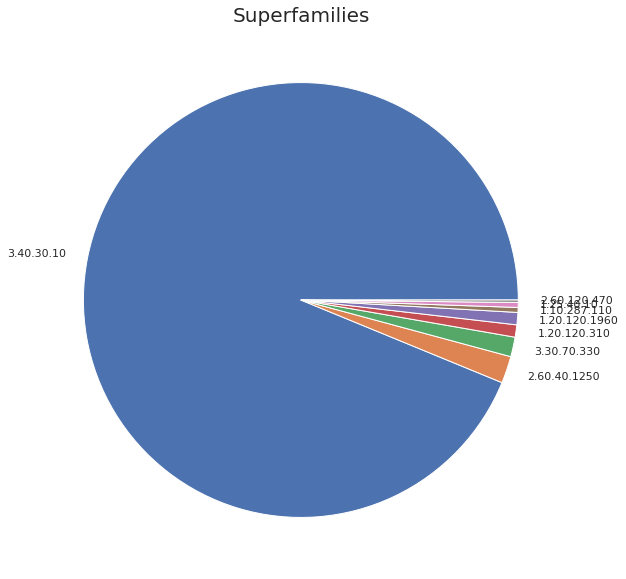

In [ ]:
fig = plt.figure(figsize=(11, 10))
_ = plt.pie(sf_count, labels= sf_count.index)
_ = plt.title("Superfamilies", fontsize = 20)

plt.savefig("../plots/cath_pie.pdf", bbox_inches='tight')

# 3 Taxonomy

## 3.1 Retrieval of `family_sequences`

In [ ]:
import requests

We now retrieve the `family_sequences` dataset in `.xml` from [UniProt](https://www.uniprot.org/uploadlists/), containing all
the UniRef90 clusters matching our model.

In [ ]:
url = 'https://www.uniprot.org/uploadlists/'

params = {
    'from': 'ACC',
    'to': 'NF90',
    'format': 'XML',
    'query': ' '.join(model_proteins),
}

response = requests.get(url, params=params)

In [ ]:
with open("../data/family_sequences.xml", "w") as f:
    for line in response.text:
        f.write(line)

## 3.2 Lineage retrieval

Firstly, we have to retrieve our proteins taxonomic IDs from the previously downloaded `family_sequences` dataset.

For doing so we parsed the `.xml` file usign the `lxml` library.

In [ ]:
from lxml import etree
from ete3 import NCBITaxa

In [ ]:
tree = etree.parse("../data/family_sequences.xml")

root = tree.getroot()
namespaces = root.nsmap

In [ ]:
taxo_ids = []

for cluster in root.getchildren():
    members = [cluster.find("representativeMember", namespaces)]
    #members.extend(cluster.findall("member", namespaces))
    for member in members:
        dbReference = member.find("dbReference", namespaces)
        for prop in dbReference.findall("property", namespaces):
            if prop.get("type") == "NCBI taxonomy":
                taxo_ids.append(prop.get("value"))

In [ ]:
# Variant using common taxon ID
taxo_ids = []

for cluster in root.getchildren():
    for prop in cluster.findall("property", namespaces):
        if prop.get("type") == "common taxon ID":
            taxo_ids.append(prop.get("value"))

In [ ]:
print(f"{len(set(taxo_ids))} unique taxonomy IDs retrieved")

151 unique taxonomy IDs retrieved


Now, using thee taxonomy library `ete3` we can compute the taxonomic tree of our collection of proteins. The update and creation of the taxonomy DB takes a while (~5 minutes with a standard CPU and Internet connection), thus if not needed skip this part and load the taxonomic tree in Newick format from `../results/taxo_tree.nh`.

In [ ]:
ncbi = NCBITaxa()
ncbi.update_taxonomy_database()

NCBI database not present yet (first time used?)
Done. Parsing...
Loading node names...
2305909 names loaded.
240351 synonyms loaded.
Loading nodes...
2305909 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /root/.etetoolkit/taxa.sqlite ...
Inserting synonyms:      15000 
Uploading to /root/.etetoolkit/taxa.sqlite

Inserting taxid merges:  30000 
Inserting taxids:       25000 
Inserting taxids:       2305000 
Updating taxdump.tar.gz from NCBI FTP site (via HTTP)...
Done. Parsing...
Loading node names...
2305909 names loaded.
240351 synonyms loaded.
Loading nodes...
2305909 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /root/.etetoolkit/taxa.sqlite ...
 2305000 generating entries... 
Uploading to /root/.etetoolkit/taxa.sqlite
Inserting synonyms:      25000 
Inserting taxid merges:  40000 
Inserting taxids:       20000 
Inserting taxids:       2305000 


In [ ]:
tree = ncbi.get_topology(taxo_ids)
tree.write(features=[], format=2, outfile="../results/taxo_tree.nh")

Finally we can extract the lineages for our sequences using the previously retrieved `taxo_ids`.

In [ ]:
with open("../results/lineages.csv", "w") as f:
    for taxo_id in taxo_ids:
        lineage = ncbi.get_lineage(taxo_id)
        translation = ncbi.translate_to_names(lineage)
        f.write(",".join(translation) + "\n")

In [ ]:
!head -n 10 ../results/lineages.csv

root,cellular organisms,Eukaryota,Opisthokonta,Metazoa,Eumetazoa,Bilateria,Protostomia,Ecdysozoa,Nematoda,Chromadorea,Rhabditida,Rhabditina,Rhabditomorpha,Rhabditoidea,Rhabditidae,Peloderinae,Caenorhabditis,Caenorhabditis elegans
root,cellular organisms,Eukaryota,Opisthokonta,Metazoa,Eumetazoa,Bilateria,Deuterostomia,Chordata,Craniata,Vertebrata,Gnathostomata,Teleostomi,Euteleostomi,Sarcopterygii,Dipnotetrapodomorpha,Tetrapoda,Amniota,Mammalia,Theria,Eutheria,Boreoeutheria,Euarchontoglires,Primates,Haplorrhini,Simiiformes,Catarrhini,Hominoidea,Hominidae,Homininae,Homo,Homo sapiens
root,cellular organisms,Eukaryota,Opisthokonta,Metazoa,Eumetazoa,Bilateria,Deuterostomia,Chordata,Craniata,Vertebrata,Gnathostomata,Teleostomi,Euteleostomi,Sarcopterygii,Dipnotetrapodomorpha,Tetrapoda,Amniota,Mammalia,Theria,Eutheria,Boreoeutheria,Euarchontoglires,Glires,Rodentia,Myomorpha,Muroidea,Muridae,Murinae,Mus,Mus,Mus musculus
root,cellular organisms,Eukaryota,Opisthokonta,Metazoa,Eumetazoa,Bilateria,

## 3.3 Taxonomic tree

In [ ]:
import toytree
import toyplot.pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's plot the tree with the ToyTree library. To do so, we have to:
* create a ToyTree object for our taxonomic tree;
* create a dictionary with abundances of our taxonomy IDs in `family_sequences`;
* put this information in the tree object;
* create a vector with the tree traversal order required by the plotting function with abundances and one for tip labels containing scientific names instead of IDs;
* plot the tree.

In [ ]:
tree = toytree.tree("../results/taxo_tree.nh", tree_format=0)

In [ ]:
taxo_counts = dict(pd.Series(taxo_ids).value_counts())

In [ ]:
for i, node in tree.idx_dict.items():
    if node.name in taxo_counts:
        node.add_feature(pr_name="abundance", pr_value=taxo_counts[node.name])

In [ ]:
sizes = np.array([int(size) if size != '' else 0 for size in tree.get_node_values("abundance", True, True)])

tips = tree.get_tip_labels()
for i in range(len(tips)):
    for node in tree.idx_dict.values():
        if node.name == tips[i]:
            tips[i] = node.sci_name.strip('_')

In [ ]:
canvas, axes, mark = tree.draw(
    tree_style='c',
    layout='c',
    height=1000,
    scalebar=False,
    tip_labels=tips,
    tip_labels_align=True,
    tip_labels_style={"font-size": "6pt"},
    node_sizes=sizes*0.5,
    node_style={"stroke": "black", "opacity": 0.5},
    edge_style={"stroke-width": 0.5},
    edge_align_style={"stroke": "black", "stroke-dasharray": 1, "stroke-width": 0.2},
);

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="tcc30cef0ebe64e1c829344ff18a18eab" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 1000.0 1000.0" width="1000.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> EscherichiacoliO157_H7 EscherichiacoliK-12 Salmonellaentericasubsp.entericaserovarTyphimuriumstr.LT2 Klebsiellapneumoniaesubsp.pneumoniaeMGH78578 CitrobacterkoseriATCCBAA-895 CronobactersakazakiiATCCBAA-894 Buchneraaphidicolastr.APS_Acyrthosiphonpisum Buchneraaphidicolastr.Sg_Schizaphisgraminum Buchneraaphidicolastr.Bp_Baizongiapistaciae Tatumellacitrea YersiniapseudotuberculosisIP32953 Yersiniaenterocoliticasubsp.enterocolitica8081 Sodalisglossinidiusstr.'morsitans' PectobacteriumatrosepticumSCRI1043 Photorhabduslaumondiisubsp.laumondiiTTO1 Haemophilus_ducreyi35000HP HaemophilusinfluenzaeRdKW20 Pasteurellamultocidasubsp.multocidastr.Pm70 Actinobacilluspleuropneumoniaeserovar5bstr.L20 VibriocholeraeO1biovarElTorstr.N16961 VibrioparahaemolyticusRIMD2210633 VibriovulnificusYJ016 Colwelliapsychrerythraea34H IdiomarinaloihiensisL2TR PseudoalteromonasatlanticaT6c PseudomonasaeruginosaPAO1 Pseudomonassp.JR1/K1 Thiocapsaroseopersicina Allochromatiumvinosum Rickettsiatyphistr.Wilmington Rickettsiaprowazekiistr.MadridE RickettsiafelisURRWXCal2 RickettsiabelliiRML369-C BradyrhizobiumdiazoefficiensUSDA110 Rhodospirillumrubrum Rhodobactersphaeroides Campylobacterjejunisubsp.jejuniNCTC11168_ATCC700819 HelicobacterpyloriJ99 NeisseriameningitidisMC58 RalstoniasolanacearumGMI1000 Acidithiobacillusferrooxidans Bacillusthuringiensis_serovarkonkukianstr.97-27 BacilluscereusATCC14579 Bacillussubtilissubsp.subtilisstr.168 OceanobacillusiheyensisHTE831 GeobacillusthermodenitrificansNG80-2 BacillushaloduransC-125 Staphylococcussaprophyticussubsp.saprophyticusATCC15305_NCTC7292 StaphylococcusepidermidisRP62A Alicyclobacillusacidocaldariussubsp.acidocaldarius ListeriainnocuaClip11262 Peptoclostridiumacidaminophilum Peptoclostridiumlitorale AcetoanaerobiumsticklandiiDSM519 Tissierellacreatinophila MycobacteriumtuberculosisvariantbovisAF2122/97 MycobacteriumtuberculosisCDC1551 MycobacteriumlepraeTN Mycolicibacteriumsmegmatis Corynebacteriumnephridii StreptomycescoelicolorA3_2 Streptomycesclavuligerus Kitasatosporaaureofaciens Mycoplasmagallisepticumstr.R_low MycoplasmapneumoniaeM129 MycoplasmagenitaliumG37 MycoplasmapulmonisUABCTIP Synechocystissp.PCC6803substr.Kazusa SynechococcuselongatusPCC7942_FACHB-805 Nostocsp.PCC7120_FACHB-418 ChloroflexusaurantiacusJ-10-fl ChlamydiatrachomatisD/UW-3/CX ChlamydiacaviaeGPIC Chlamydiapneumoniae ChlorobaculumtepidumTLS Chlorobaculumthiosulfatiphilum Treponemapallidumsubsp.pallidumstr.Nichols BorreliellaburgdorferiB31 Musmusculus Rattusnorvegicus Mesocricetusauratus Caviaporcellus Oryctolaguscuniculus Homosapiens Pongoabelii Macacamulatta Callithrixjacchus Ovisaries Bostaurus Susscrofa Equuscaballus Gallusgallus Ophiophagushannah Xenopustropicalis Xenopuslaevis Daniorerio Ictaluruspunctatus Cionaintestinalis Heliocidariscrassispina Caenorhabditiselegans Caenorhabditisbriggsae Drosophilamelanogaster Echinococcusgranulosus Schistosomamansoni Geodiacydonium AspergillusoryzaeRIB40 Aspergillusniger AspergillusnidulansFGSCA4 Aspergillusfumigatus Penicilliumchrysogenum TrichophytonbenhamiaeCBS112371 NeurosporacrassaOR74A Humicolainsolens Fusariumculmorum Alternariaalternata SaccharomycescerevisiaeS288C Schizosaccharomycespombe972h- Coprinuscomatus Malasseziasympodialis Pisumsativum Medicagosativa Ricinuscommunis Populusxjackii Datiscaglomerata Brassicarapa Brassicanapus Arabidopsisthaliana Nicotianabenthamiana Nicotianatabacum Solanumlycopersicum Spinaciaoleracea Fagopyrumesculentum 

In [ ]:
toyplot.pdf.render(canvas, "../plots/taxon_tree.pdf")

In order to reduce the memory space, we remove `taxdump` files.

In [ ]:
!rm taxdump*

# 4 Functional characterization

In [ ]:
import gzip
import fisher
import json
from GO import get_entries, parse_xml_entry
from lxml import etree

In [ ]:
!wget -P ../data/ http://purl.obolibrary.org/obo/go.obo

## 4.1 Annotations retrieval from `family_sequences` 

Retrive every GO annotation for all the proteins retrieved from Uniprot comparing
the results obtained from our model with UniRef90.

In [ ]:
tree = etree.parse("../data/family_sequences.xml")

root = tree.getroot()
namespaces = root.nsmap

In [ ]:
go_dict={}

for cluster in root.getchildren():
    go_dict[cluster.get("id")[9:]]=[]
    for prop in cluster.findall("property", namespaces):
        if prop.get("type").startswith("GO"):
            go_dict[cluster.get("id")[9:]].append(prop.get("value"))

## 4.2 SwissProt annotations retrival

To compute the enrichment of our terms we need a dictionary mapping each accession code in Swissprot to GO terms (if present), thus keeping SwissProt as reference DB. This operation can last for about half an hour, you can skip it and use the one we provide in `../data/sprot_annotations.json`.

In [ ]:
!wget -P ../data/ ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.xml.gz

In [ ]:
GO_Uniprot = {}

with gzip.open("../data/uniprot_sprot.xml.gz") as f:
    i = 0
    for entry in get_entries(f):
        accession, annotations = parse_xml_entry(entry)
        if len(annotations) > 0:
            GO_Uniprot[accession] = annotations
            i += 1
            if i%1000 == 0:
                print(f"{i} accessions processed", end="\r")

We can dump this dictionary to a `.json` file and remove the SwissProt `.xml` to free some memory.

In [ ]:
with open("../data/sprot_annotations.json", "w") as f:
    json.dump(GO_Uniprot, f)

In [ ]:
!rm ../data/uniprot_sprot.xml.gz

## 4.3 Enrichment of GO terms

In [ ]:
from GO import parse_obo, get_ancestors, get_children
import fisher
import json
import copy
import pandas as pd
import numpy as np
from wordcloud import WordCloud

First, we import the gene ontology and we build the tree object.

In [ ]:
graph = parse_obo("../data/go.obo")
ancestors, depth, roots = get_ancestors(graph)
children = get_children(ancestors)

Then, we can import the `.json` of SwissProt annotation that we generated in the previous section.

In [ ]:
with open("../data/sprot_annotations.json", "r") as f:
    GO_Uniprot = json.load(f)

In the following cells we compute the enrichment for each GO term of `family_structure` using the Fisher exact test.

In [ ]:
terms_set = {}
terms_rest = {} 
proteins_set = 0
proteins_rest = 0
    
for acc, annotations in GO_Uniprot.items():
            
    # Copy direct annotations
    terms = copy.copy(set(annotations))

    # Add ancestors
    for term in set(annotations):
        terms.update(ancestors.get(term, set()))
        
    # For each term add protein accession to proteins dict
    if acc in go_dict.keys():
        proteins_set += 1
        for term in terms:
            terms_set.setdefault(term, 0)
            terms_set[term] += 1
    else:
        proteins_rest += 1
        for term in terms:
            terms_rest.setdefault(term, 0)
            terms_rest[term] += 1

In [ ]:
data = []
for term in terms_set:
    ratio_set = (terms_set[term] + 1) / proteins_set  # add pseudo count
    ratio_rest = terms_rest.get(term, 1) / proteins_rest  # add pseudo count
    fold_increase = ratio_set / ratio_rest
    p = fisher.pvalue(terms_set[term], proteins_set, terms_rest.get(term,0), proteins_rest)

    data.append((term, p.left_tail, p.right_tail, p.two_tail, fold_increase))

In [ ]:
GO_df = pd.DataFrame(data, columns=['GOi', 'l_p', 'r_p', 'two_p', 'fold_inc'])
GO_df.set_index("GOi", inplace=True)
GO_df.sort_values("r_p", ascending=True, inplace=True)

After computing Fisher's exact test, we compute a reasonable score based on the right tail $p$-value to display in a pleasant way the most enriched GO terms in a wordcloud, considering only the first 50 terms with the highest score.

In [ ]:
GO_df['score'] = np.log(1 / (1e-300 + GO_df['r_p']))

In [ ]:
for GOi in GO_df.index:
    # Some terms might be obsolete, thus not present in the GO tree
    if GOi in children:
        GO_df.loc[GOi, 'n_children'] = len(children[GOi])
    else:
        GO_df.loc[GOi, 'n_children'] = 0
    if GOi in graph:
        GO_df.loc[GOi, 'def'] = graph[GOi]['def']

GO_df.dropna(subset=['def'], inplace=True)

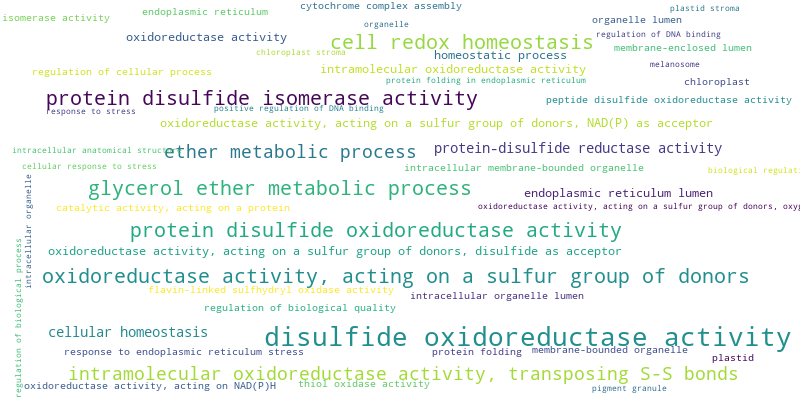

In [ ]:
wc = WordCloud(
    background_color="white",
    colormap = 'viridis',
    max_words = 50,
    #width = 500,
    #height = 500,
    scale = 2,
)

frequencies = GO_df.set_index('def').score
wc.generate_from_frequencies(frequencies)
wc.to_file("../plots/wc.pdf")
wc.to_image()

## 4.4 Most significantly enriched high level terms

We want to select GO annotations that are at the same time far from the leaves and significantly enriched. To do so we filter:
* using a threshold for $p$-value to get only significant terms;
* using the $\alpha$-quantile to keep only the terms with a significative amount of descendats.

In [ ]:
threshold = 1e-20
alpha = .75

GO_df[(GO_df.r_p < threshold) & (GO_df.n_children > GO_df.n_children.quantile(alpha))].sort_values('n_children', ascending= False)

,l_p,r_p,two_p,fold_inc,score,n_children,def
GOi,,,,,,,
GO:0065007,1.0,1.658822e-24,3.300754e-06,2.648057,54.755935,12126.0,biological regulation
GO:0050789,1.0,8.955510e-25,3.444146e-06,2.723640,55.372358,10902.0,regulation of biological process
GO:0050794,1.0,1.112030e-30,3.447097e-06,3.153176,68.971365,8243.0,regulation of cellular process
GO:0016491,1.0,1.036562e-93,2.812394e-06,6.487633,214.104504,2425.0,oxidoreductase activity
GO:0065008,1.0,1.412070e-69,1.766988e-06,7.409057,158.533314,1501.0,regulation of biological quality
GO:0140096,1.0,4.075226e-30,2.030758e-06,4.240830,67.672627,482.0,"catalytic activity, acting on a protein"
GO:0042592,1.0,2.086735e-129,4.754734e-07,21.778317,296.297876,292.0,homeostatic process
GO:0016853,1.0,7.013755e-59,1.117627e-06,8.973224,133.904647,264.0,isomerase activity
GO:0043227,1.0,1.622298e-35,3.241162e-06,3.364857,80.106634,219.0,membrane-bounded organelle
